File structure
Folder and files in main directory:
- model.py
- Behavior-Cloning.ipynb
- model.json
- model.h5
- drive.py
- driving_log.csv
- 'IMG' folder
    -- 'All .jpg images'

In [1]:
# Get training dataset from Udacity website

# Imports
from urllib.request import urlretrieve
from os.path import isfile
from tqdm import tqdm
import zipfile
import shutil

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('driving_log.csv'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Train Dataset') as pbar:
        urlretrieve(
            'https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip',
            'data.zip',
            pbar.hook)

    # Unzip data set
    zip_ref = zipfile.ZipFile('data.zip', 'r')
    zip_ref.extractall('')
    zip_ref.close()

    # Move dataset to folder location
    shutil.move('data/IMG/','IMG')
    shutil.move('data/driving_log.csv','driving_log.csv')
    
    print('Training data downloaded.')

In [2]:
# Imports
import pickle
import numpy as np
import math

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

print('Modules loaded.')

Modules loaded.


In [3]:
# Load the images

# Imports
import os
import os.path
from PIL import Image
import numpy as np

img_path = os.getcwd()+'/IMG'
imgs = np.empty((0,160,320,3))
valid_ext = [".jpg"]


for f in os.listdir(img_path):
    f_ext = os.path.splitext(f)[1]
    if f_ext.lower() not in valid_ext:
        continue
    img = np.squeeze(Image.open(os.path.join(img_path,f)))
    imgs = np.append(imgs, np.expand_dims(img, axis=0),axis=0)
    imgs = imgs.astype(np.uint8)
    print(len(imgs),' images are loaded')
    
    if len(imgs) == 1000:
        break
    
print('All images loaded.')

1  images are loaded
2  images are loaded
3  images are loaded
4  images are loaded
5  images are loaded
6  images are loaded
7  images are loaded
8  images are loaded
9  images are loaded
10  images are loaded
11  images are loaded
12  images are loaded
13  images are loaded
14  images are loaded
15  images are loaded
16  images are loaded
17  images are loaded
18  images are loaded
19  images are loaded
20  images are loaded
21  images are loaded
22  images are loaded
23  images are loaded
24  images are loaded
25  images are loaded
26  images are loaded
27  images are loaded
28  images are loaded
29  images are loaded
30  images are loaded
31  images are loaded
32  images are loaded
33  images are loaded
34  images are loaded
35  images are loaded
36  images are loaded
37  images are loaded
38  images are loaded
39  images are loaded
40  images are loaded
41  images are loaded
42  images are loaded
43  images are loaded
44  images are loaded
45  images are loaded
46  images are load

In [17]:
# Load the driving log data

# Imports
import csv, sys

filename = 'driving_log.csv'
angles = []
imgs_fname = []

with open(filename, 'rt') as csvfile:
    
    # Load driving angle data
    anglereader = csv.reader(csvfile, delimiter=',')

    try:
        for row in anglereader:
            angles.append(row[-1])
          
            fln = row[0].split('/')
            imgs_fname.append(fln[-1])
            
            print(len(angles),' angles are loaded')
            

                
    except csv.Error as e:
        sys.exit('file %s, line %d: %s' % (filename, reader.line_num, e)) 

print('All Driving driving log data loaded.')

1  angles are loaded
2  angles are loaded
3  angles are loaded
4  angles are loaded
5  angles are loaded
6  angles are loaded
7  angles are loaded
8  angles are loaded
9  angles are loaded
10  angles are loaded
11  angles are loaded
12  angles are loaded
13  angles are loaded
14  angles are loaded
15  angles are loaded
16  angles are loaded
17  angles are loaded
18  angles are loaded
19  angles are loaded
20  angles are loaded
21  angles are loaded
22  angles are loaded
23  angles are loaded
24  angles are loaded
25  angles are loaded
26  angles are loaded
27  angles are loaded
28  angles are loaded
29  angles are loaded
30  angles are loaded
31  angles are loaded
32  angles are loaded
33  angles are loaded
34  angles are loaded
35  angles are loaded
36  angles are loaded
37  angles are loaded
38  angles are loaded
39  angles are loaded
40  angles are loaded
41  angles are loaded
42  angles are loaded
43  angles are loaded
44  angles are loaded
45  angles are loaded
46  angles are load

The image dimensions are:  (160, 320, 3)
The image filename is:  center_2016_12_01_13_32_51_437.jpg
The driving angle is:   30.18687


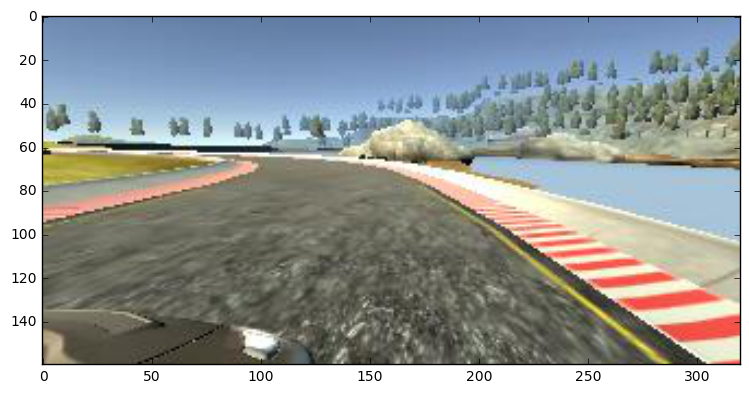

In [5]:
# Verify that the images and driving data are loaded correctly
# Display random sample image and matching driving data

# Imports
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

index = random.randint(0, len(imgs)-1)
image = imgs[index]
plt.figure(figsize=(9,9))
plt.imshow(image)

print('The image dimensions are: ',image.shape)
print('The image filename is: ',imgs_fname[index])
print('The driving angle is: ',angles[index])

In [6]:
# Set up train data
X_train, y_train = imgs, angles

In [7]:
# Summary of Dataset information

# Number of training examples
n_train = X_train.shape[0]

# Shape of an traffic sign image
image_shape = X_train[0].shape

# Number of unique classes/labels there are in the dataset
n_classes = len(np.unique(y_train))

# Display information
print("Number of training examples =", n_train)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 1000
Image data shape = (160, 320, 3)
Number of classes = 419


In [8]:
# Preprocessing functions for image set

# Imports
import cv2

def preprocess_set(img):
    
    img_gr = grayscale_set(img)
    img_nm = normalize_set(img_gr)
    img_p = np.expand_dims(img_nm, axis=3)
    
    return img_p
    
# Grayscale image set
def grayscale_set(img):
    img_gr = []
    
    for i in range(0,len(img)):
        img_gr.append(cv2.cvtColor(img[i],cv2.COLOR_BGR2GRAY))

    return img_gr

# Normalize image set (values between 0-1)
def normalize_set(img):
    grayscale_max = 255
    img_nm = []
    
    for i in range(0,len(img)):
        img_nm.append(img[i]/grayscale_max)
    
    return img_nm

In [9]:
# Shuffle training image set

# Imports
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [10]:
# Preprocess training and validation image sets
X_train = preprocess_set(X_train)

In [11]:
# One Hot encode the labels to the variable y_one_hot

# Imports
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()
y_train_one_hot = label_binarizer.fit_transform(y_train)

In [12]:
# Set up train and validation data

# Imports
from sklearn.cross_validation import train_test_split

# Split data into train and validation data
X_train, X_validation, y_train_one_hot, y_validation_one_hot = train_test_split(X_train, y_train_one_hot, train_size = 0.8)

/home/carnd/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
# CHOOSE TO IMPORT MODEL AND WEIGHTS
# OPTIONAL: import model.json and model.h5

# Imports
import json
from keras.models import model_from_json

# Load the model from model.json
json_data=open('model.json').read()
json_string = json.loads(json_data)
model = model_from_json(json_string)

#Load the weights from model.h5
model.load_weights('model.h5', by_name=True)

Using TensorFlow backend.


OSError: Unable to open file (Unable to open file: name = 'model.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [14]:
# CHOOSE TO SET UP NEW MODEL AND WEIGHTS

# Network model

# Imports
from keras.models import Sequential
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

# Parameters
n_classes = len(np.unique(y_train))

model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(160, 320, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

In [18]:
# Define train batch generator

# Imports
import math

# Parameters
batch_size = 32

def generate_batch(X_train, y_train_one_hot, batch_size):
    
    batch_max = math.floor(len(X_train)/batch_size)
    
    while 1:
        for batch_num in range (batch_max):
            if batch_num > batch_max:
                return
            X_train_batch = X_train[batch_num*batch_size:(batch_num+1)*batch_size]
            y_train_one_hot_batch = y_train_one_hot[batch_num*batch_size:(batch_num+1)*batch_size]
            yield X_train_batch, y_train_one_hot_batch 

# Compile and train the mod
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

history = model.fit_generator(generate_batch(X_train, y_train_one_hot, batch_size),
                              samples_per_epoch = len(X_train), nb_epoch = 500, 
                              validation_data = (X_validation, y_validation_one_hot), verbose = 1)

Epoch 1/500
800/800 [==============================] - 7s - loss: 5.0415 - acc: 0.0713 - val_loss: 6.9486 - val_acc: 0.0700

In [16]:
# Save the model and weights

# Imports
from keras.models import model_from_json
import json

# Save the model to model.json
json_string = model.to_json()
with open('model.json', 'w') as f:
     json.dump(json_string, f)

# Save the weights to model.h5
model.save_weights('model.h5')